In [6]:
!unzip flowers17.zip

Archive:  flowers17.zip
   creating: flowers17/
   creating: flowers17/bluebell/
  inflating: flowers17/bluebell/image_0241.jpg  
  inflating: flowers17/bluebell/image_0242.jpg  
  inflating: flowers17/bluebell/image_0243.jpg  
  inflating: flowers17/bluebell/image_0244.jpg  
  inflating: flowers17/bluebell/image_0245.jpg  
  inflating: flowers17/bluebell/image_0246.jpg  
  inflating: flowers17/bluebell/image_0247.jpg  
  inflating: flowers17/bluebell/image_0248.jpg  
  inflating: flowers17/bluebell/image_0249.jpg  
  inflating: flowers17/bluebell/image_0250.jpg  
  inflating: flowers17/bluebell/image_0251.jpg  
  inflating: flowers17/bluebell/image_0252.jpg  
  inflating: flowers17/bluebell/image_0253.jpg  
  inflating: flowers17/bluebell/image_0254.jpg  
  inflating: flowers17/bluebell/image_0255.jpg  
  inflating: flowers17/bluebell/image_0256.jpg  
  inflating: flowers17/bluebell/image_0257.jpg  
  inflating: flowers17/bluebell/image_0258.jpg  
  inflating: flowers17/bluebell/image

In [7]:
!pip install keras_cv
!pip install keras_core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.2/756.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 924.6/924.6 kB 8.5 MB/s eta 0:00:00


In [8]:
import imutils
import cv2


class AspectAwarePreprocessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        self.width = width
        self.height = height
        self.inter = inter

    def preprocess(self, image):
        (h, w) = image.shape[:2]
        dW = 0
        dH = 0

        # resize wrt shortest img dimension
        if w < h:
            image = imutils.resize(image, width=self.width, inter=self.inter)
            dH = int((image.shape[0] - self.height) / 2.0)
        else:
            image = imutils.resize(image, height=self.height, inter=self.inter)
            dW = int((image.shape[1] - self.width) / 2.0)

        # crop to achieve desired image size
        (h, w) = image.shape[:2]
        image = image[dH: h - dH, dW: w - dW]

        # resize again to ensure no rounding errors after cropping
        return cv2.resize(image, (self.width, self.height), interpolation=self.inter)

In [9]:
from keras.utils.image_utils import img_to_array


class ImageToArrayPreprocessor:
    def __init__(self, data_format=None):
        self.data_format = data_format

    def preprocess(self, image):
        return img_to_array(image, data_format=self.data_format)

In [10]:
import numpy as np
import cv2
import os


class SimpleDatasetLoader:
    def __init__(self, preprocessors=None):
        # store img preprocessor
        self.preprocessors = preprocessors

        if self.preprocessors is None:
            self.preprocessors = []

    def load(self, image_paths: list[str], verbose=-1) -> tuple[np.ndarray, np.ndarray]:
        data = []
        labels = []

        for (i, image_path) in enumerate(image_paths):
            # load img and extract class label assuming
            # path has following format:
            # /path/to/dataset/{class}/{image}.jpg
            image = cv2.imread(image_path)
            label = image_path.split(os.path.sep)[-2]

            if self.preprocessors is not None:
                for p in self.preprocessors:
                    image = p.preprocess(image)

                data.append(image)
                labels.append(label)

            if verbose > 0 and i > 0 and (i+1) % verbose == 0:
                print(f"[INFO] processed {i+1}/{len(image_paths)}")

        return np.array(data), np.array(labels)

In [11]:
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K


class MiniVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        if K.image_data_format() == "channels_first":
            input_shape = (depth, height, width)
            chan_dim = 1
        else:
            input_shape = (height, width, depth)
            chan_dim = -1

        # first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), padding="same", input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # First and only set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model

In [12]:
import matplotlib.pyplot as plt
from keras.models import Sequential
import numpy as np


def plot_training_loss_and_accuracy_keras(epoch_num: int, H: Sequential.fit, savefig_path=None):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, epoch_num), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epoch_num), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epoch_num), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epoch_num), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss / Accuracy")
    plt.legend()
    if savefig_path:
        plt.savefig(savefig_path)
    plt.show()

In [13]:
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

print("[INFO] loading images...")
image_paths = list(paths.list_images("/content/flowers17"))
class_names = list(set(pt.split(os.path.sep)[-2] for pt in image_paths))

aap = AspectAwarePreprocessor(64, 64)
iap = ImageToArrayPreprocessor()

sdl = SimpleDatasetLoader(preprocessors=[aap, iap])
(data, labels) = sdl.load(image_paths, verbose=500)
data = data.astype("float") / 255.0

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)
trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)

[INFO] loading images...
[INFO] processed 500/1360
[INFO] processed 1000/1360


In [15]:
from keras.optimizers import SGD
from keras import Sequential
from keras_cv.layers import RandomFlip, RandomRotation, RandomTranslation, RandomZoom, RandomShear

print("[INFO] compling model...")
data_augmentation = Sequential([
    RandomRotation(0.1),
    RandomTranslation(height_factor=0.1, width_factor=0.1),
    RandomShear(0.2),
    RandomZoom(0.2),
    RandomFlip("horizontal"),
])

model = MiniVGGNet.build(width=64, height=64, depth=3, classes=len(class_names))
model = Sequential([data_augmentation, model])
opt = SGD(learning_rate=0.05)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compling model...


In [16]:
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=32, epochs=100, verbose=1)

[INFO] training network...
Epoch 1/100
32/32 [==============================] - 17s 81ms/step - loss: 3.5620 - accuracy: 0.1735 - val_loss: 3.6068 - val_accuracy: 0.1441
Epoch 2/100
32/32 [==============================] - 1s 30ms/step - loss: 2.5488 - accuracy: 0.3314 - val_loss: 2.5492 - val_accuracy: 0.2294
Epoch 3/100
32/32 [==============================] - 1s 26ms/step - loss: 2.2446 - accuracy: 0.3676 - val_loss: 2.4724 - val_accuracy: 0.2941
Epoch 4/100
32/32 [==============================] - 1s 24ms/step - loss: 2.0227 - accuracy: 0.4059 - val_loss: 2.6880 - val_accuracy: 0.2118
Epoch 5/100
32/32 [==============================] - 1s 24ms/step - loss: 1.8247 - accuracy: 0.4402 - val_loss: 2.8322 - val_accuracy: 0.2412
Epoch 6/100
32/32 [==============================] - 1s 26ms/step - loss: 1.6411 - accuracy: 0.4990 - val_loss: 2.1831 - val_accuracy: 0.3471
Epoch 7/100
32/32 [==============================] - 1s 26ms/step - loss: 1.6248 - accuracy: 0.5059 - val_loss: 2.3540 -

[INFO] evaluating network...
11/11 [==============================] - 2s 15ms/step
              precision    recall  f1-score   support

   tigerlily       0.65      0.89      0.75        27
   sunflower       0.69      0.86      0.77        21
      crocus       0.75      0.60      0.67        20
     cowslip       0.61      0.93      0.74        15
    daffodil       0.33      0.39      0.36        18
   dandelion       0.60      0.50      0.55        18
       tulip       0.69      1.00      0.82        20
       pansy       0.75      0.75      0.75        16
        iris       0.88      0.75      0.81        20
  fritillary       0.85      0.58      0.69        19
 lily_valley       0.57      0.81      0.67        16
  windflower       0.88      0.74      0.80        19
   buttercup       0.65      0.57      0.60        23
    bluebell       0.88      0.91      0.89        23
       daisy       1.00      0.80      0.89        20
  colts_foot       0.53      0.35      0.42        2

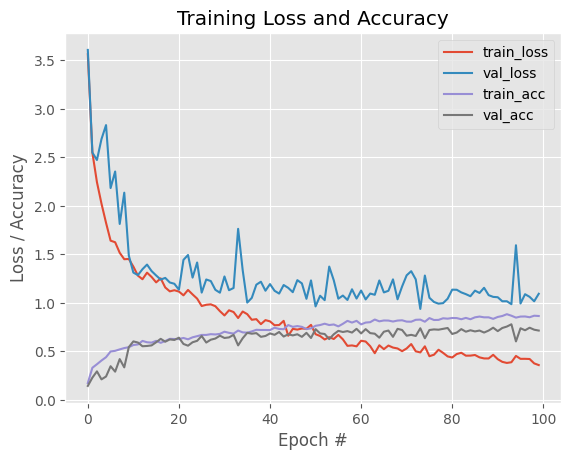

In [17]:
from sklearn.metrics import classification_report

print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=class_names))

plot_training_loss_and_accuracy_keras(
    epoch_num=100,
    H=H
)